In [12]:
#############
###paths#####
#############
import sys
import os

pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1] 
sys.path.append(modellingpath + '/lib')
#############
import pickle as pkl
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit


In [13]:

def plotData(inducer, rfpExp_list, gfpExp_list, semRed, semGreen,pad=0.01, inducerName='OC14'):
    fig,ax = plt.subplots()

    ax.plot(inducer,rfpExp_list,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer,gfpExp_list,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')
    ax.set_xlabel(f'{inducerName} concentration (µM)')

    plt.show()

def plotFitvsData(inducer,inducer_continuous, gfpExp_list, rfpExp_list, semGreen, semRed,doseResponseGreen,doseResponseRed,pad=0.01):
    fig,ax = plt.subplots()

    ax.plot(inducer_continuous,doseResponseRed,label='RFP', c='red')
    ax.scatter(inducer,rfpExp_list, c='red')
    ax.errorbar(inducer,rfpExp_list,yerr=semRed,c='red',fmt='o')
    ax.legend(loc='center left') #upper right
    ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$')
    ax.set_xscale('log')


    ax2=ax.twinx()
    ax2.plot(inducer_continuous,doseResponseGreen,label='GFP', c='green')
    ax2.scatter(inducer,gfpExp_list, c='green')
    ax2.errorbar(inducer,gfpExp_list,yerr=semGreen,c='green',fmt='o')
    ax2.legend(loc='center right') #upper left
    ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$')
    ax.set_xscale('log')


    plt.show()


## 2 combined parameters, original dataset

In [15]:

nvd = 2
nfe = 5
nda=2
nce=3

def gfp1_steadystate(OC14, Vf,Kvd): 
    muv = 0.0225 ; kv =  0.0183 ;
    F1 = 1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))
    return F1

def rfp1_steadystate(OC14, Vf,Kvd,VeKfenfe): 
    muv = 0.0225 ; kv =  0.0183 ;
    E1 = 1 + VeKfenfe*(1/(1+((1 + Vf*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))))**nfe))

    return E1


def gfp3_steadystate(OC14,  Vd,Kvd): 
    muv = 0.0225 ; kv =  0.0183 ;
    D3 = 1 + Vd*(1/(1+((muv*Kvd)/(kv*OC14 + 1e-8))**nvd ))
    return D3

def bfp3_steadystate(D,VcKdanda): 
    C3= 1 + VcKdanda*(1/(1+((D)**nda)))
    return C3

def rfp3_steadystate(OC14,  Vd,Kvd,VcKdanda,  VeKcence): 
    E3 = 1 + VeKcence*(1/(1+((bfp3_steadystate(gfp3_steadystate(OC14,  Vd,Kvd), VcKdanda))**nce)))
    return E3


OC14_continuous = np.logspace(-3,1, 100)


def steadystate(OC14,Vf,Vd, Kvd, VeKfenfe, VcKdanda, VeKcence):
  
  if len(OC14) == 22:
      gaps = [5,5,6,6]
  else:
        gaps = [int(len(OC14)/4)]*4
  F1 = gfp1_steadystate(OC14[:np.sum(gaps[:1])],  Vf,Kvd)
  E1 = rfp1_steadystate(OC14[np.sum(gaps[:1]):np.sum(gaps[:2])],Vf,Kvd,VeKfenfe)
  D3 = gfp3_steadystate(OC14[np.sum(gaps[:2]):np.sum(gaps[:3])], Vd,Kvd)
  E3 = rfp3_steadystate(OC14[np.sum(gaps[:3]):np.sum(gaps[:4])],  Vd,Kvd,VcKdanda,  VeKcence)
  FE = np.hstack([F1,E1, D3, E3])
  return FE


fluorescenceData = np.hstack([gfpExp_list1,rfpExp_list1, gfpExp_list3,rfpExp_list3])
OC14data_new = np.hstack([OC14_list1,OC14_list1, OC14_list3,OC14_list3])
OC14data_continuous= np.hstack([OC14_continuous,OC14_continuous, OC14_continuous,OC14_continuous])
semStacked= np.hstack([semGreen1,semRed1, semGreen3,semRed3])

popt, pcov = curve_fit(f=steadystate, xdata=OC14data_new, ydata=fluorescenceData ,sigma =semStacked, bounds = (0,100), maxfev = 100000000)

paramNames = ['Vf','Vd', 'Kvd', 'VeKfenfe', 'VcKdanda', 'VeKcence']
pfitDict = {}
for param in popt:
    pfitDict[paramNames[popt.tolist().index(param)]] = param


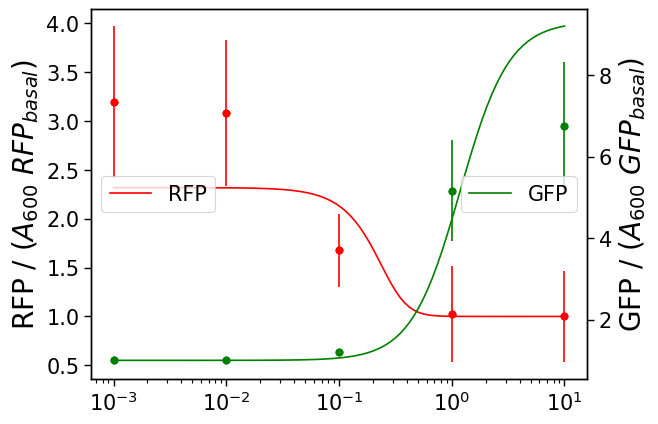

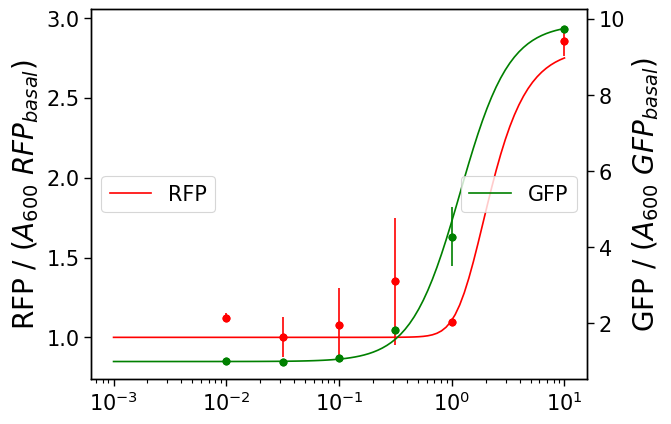

In [16]:
fluorescenceFit = steadystate(OC14data_new, *popt)
fluorescenceFit_continuous = steadystate(OC14data_continuous, *popt)
gfpFit1 = fluorescenceFit[:5]; rfpFit1 = fluorescenceFit[5:10]; gfpFit3 = fluorescenceFit[10:16]; rfpFit3 = fluorescenceFit[16:22]
gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]

plotFitvsData(OC14_list1,OC14_continuous, gfpExp_list1, rfpExp_list1, semGreen1, semRed1, gfpFit1_continuous,rfpFit1_continuous)

plotFitvsData(OC14_list3,OC14_continuous, gfpExp_list3, rfpExp_list3, semGreen3, semRed3, gfpFit3_continuous,rfpFit3_continuous)
gfpFit1_continuous_copy,rfpFit1_continuous_copy, gfpFit3_continuous_copy,rfpFit3_continuous_copy = gfpFit1_continuous,rfpFit1_continuous, gfpFit3_continuous,rfpFit3_continuous 

In [18]:


sampled_parameters = np.random.multivariate_normal(popt,pcov, size=100, check_valid='warn')#
filtered_parameters = [p for p in sampled_parameters if np.all(p>0)]



In [22]:
def steadystateloss(OC141, OC143,Vf,Vd, Kvd, VeKfenfe, VcKdanda, VeKcence):

  F1 = gfp1_steadystate(OC141,  Vf,Kvd)
  E1 = rfp1_steadystate(OC141,Vf,Kvd,VeKfenfe)
  D3 = gfp3_steadystate(OC143, Vd,Kvd)
  E3 = rfp3_steadystate(OC143,  Vd,Kvd,VcKdanda,  VeKcence)
  # FE = np.hstack([F1,E1, D3, E3])
  FE = [F1,E1, D3, E3]

  return FE

def func(p):
    loss_i = 0

    for count,OC14 in enumerate(OC14_list1):
      model= steadystateloss(OC14_list1[count],OC14_list3[count],*p)

      loss_i+= ((gfpExp_list1[count] - model[0])**2 + (rfpExp_list1[count] - model[1])**2 +(gfpExp_list3[count] - model[2])**2 + (rfpExp_list3[count] - model[3])**2 )
      # loss_i+= (((gfpExp_list[count] - model[0])**2)/(semGreen.values[count]+1e-8)+ ((rfpExp_list[count] - model[1])**2)/(semRed.values[count]+1e-8))
      # loss_i+= (gfpExp_list[count] - model)**2
    
    return loss_i

lossList = []
for p in filtered_parameters:
   lossList.append(func(p))


In [39]:
len(filtered_parameters)
pfit_df = pd.DataFrame(filtered_parameters, columns=[paramNames])
pfit_df['Ve']=1
# pfit_df['Kfe'] = (pfit_df['Ve']* pfit_df['VeKfenfe'])**(-5)
pfit_df['Kfe'] =np.multiply( pfit_df['Ve'], pfit_df['VeKfenfe'])**(-nfe)
pfit_df


/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_5689/1108564359.py:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  pfit_df['Kfe'] =np.multiply( pfit_df['Ve'], pfit_df['VeKfenfe'])**(-nfe)


,Vf,Vd,Kvd,VeKfenfe,VcKdanda,VeKcence,Ve,Kfe
0,3.321723,8.809637,1.120406,4.178431,129.312172,28.939805,1,0.000785
1,10.463089,9.083889,0.848675,4.009675,119.433936,16.621095,1,0.000965
2,4.322210,9.165271,0.983180,1.504068,59.484227,1.212173,1,0.129916
3,11.091167,9.654632,1.142816,2.844182,44.375168,1.670746,1,0.005373
4,4.394417,9.461005,0.853966,2.512569,169.895966,27.180703,1,0.009986
...,...,...,...,...,...,...,...,...
63,13.383253,8.707758,0.886998,3.162050,145.639843,31.408880,1,0.003163
64,2.239369,8.939112,0.915804,0.597715,118.447261,23.349047,1,13.107739
65,22.166426,9.147766,0.811815,3.169973,171.774278,37.338912,1,0.003124
66,5.471175,8.795150,0.779113,1.842251,155.994529,32.101460,1,0.047126


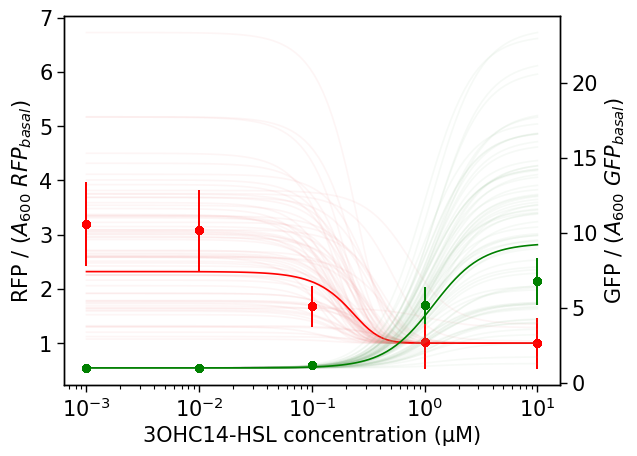

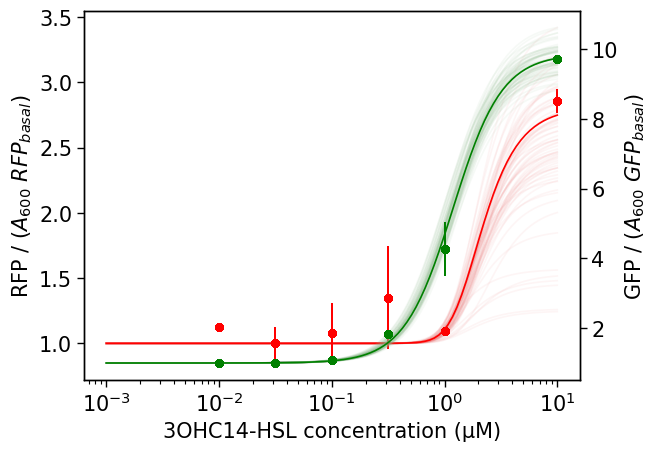

In [20]:

fig,ax = plt.subplots()
ax2=ax.twinx()
OC14_continuous = np.logspace(-3,1,100)

for p in filtered_parameters:
    fluorescenceFit = steadystate(OC14data_new, *p)
    fluorescenceFit_continuous = steadystate(OC14data_continuous, *p)
    fluorescenceSingleFit_continuous = steadystate(OC14data_continuous, *popt)
    gfpFit1 = fluorescenceFit[:5]; rfpFit1 = fluorescenceFit[5:10]; gfpFit3 = fluorescenceFit[10:16]; rfpFit3 = fluorescenceFit[16:22]
    gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]
    gfpSingleFit1_continuous = fluorescenceSingleFit_continuous[:100]; rfpSingleFit1_continuous = fluorescenceSingleFit_continuous[100:200]; gfpSingleFit3_continuous = fluorescenceSingleFit_continuous[200:300]; rfpSingleFit3_continuous = fluorescenceSingleFit_continuous[300:400]
#     steadystate(OC14_continuous, *p)
    ax2.plot(OC14_continuous, gfpFit1_continuous, c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, rfpFit1_continuous, c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list1,gfpExp_list1 , label='data', c='green')
    ax2.errorbar(OC14_list1,gfpExp_list1,yerr=semGreen1,c='green',fmt='o')
    ax.scatter(OC14_list1,rfpExp_list1 , label='data', c='red')
    ax.errorbar(OC14_list1,rfpExp_list1,yerr=semRed1,c='red',fmt='o')
    plt.xscale('log')

# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$',fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)',fontsize=15)
ax.plot(OC14_continuous, rfpFit1_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit1_continuous_copy, c='green', alpha=1)
plt.show()

gfpFit1_continuous_copy
fig,ax = plt.subplots()
ax2=ax.twinx()
for p in filtered_parameters:
    fluorescenceFit = steadystate(OC14data_new, *p)
    fluorescenceFit_continuous = steadystate(OC14data_continuous, *p)
    gfpFit1 = fluorescenceFit[:5]; rfpFit1 = fluorescenceFit[5:10]; gfpFit3 = fluorescenceFit[10:16]; rfpFit3 = fluorescenceFit[16:22]
    gfpFit1_continuous = fluorescenceFit_continuous[:100]; rfpFit1_continuous = fluorescenceFit_continuous[100:200]; gfpFit3_continuous = fluorescenceFit_continuous[200:300]; rfpFit3_continuous = fluorescenceFit_continuous[300:400]
    
    ax2.plot(OC14_continuous, gfpFit3_continuous, c='darkseagreen', alpha=0.08)
    ax.plot(OC14_continuous, rfpFit3_continuous, c='lightcoral', alpha=0.08)
    ax2.scatter(OC14_list3,gfpExp_list3 , label='data', c='green')
    ax2.errorbar(OC14_list3,gfpExp_list3,yerr=semGreen3,c='green',fmt='o')
    ax.scatter(OC14_list3,rfpExp_list3 , label='data', c='red')
    ax.errorbar(OC14_list3,rfpExp_list3,yerr=semRed3,c='red',fmt='o')
    plt.xscale('log')


# ax.legend(loc='center left') #upper right
ax.set_ylabel('RFP / ($A_{600}$ $RFP_{basal})$', fontsize=15)
ax.set_xscale('log')
# ax2.legend(loc='center right') #upper left
ax2.set_ylabel('GFP / ($A_{600}$ $GFP_{basal})$', fontsize=15)
ax.set_xscale('log')
ax.set_xlabel(f'3OHC14-HSL concentration (µM)', fontsize=15)

ax.plot(OC14_continuous, rfpFit3_continuous_copy, c='red', alpha=1)
ax2.plot(OC14_continuous, gfpFit3_continuous_copy, c='green', alpha=1)
plt.show()

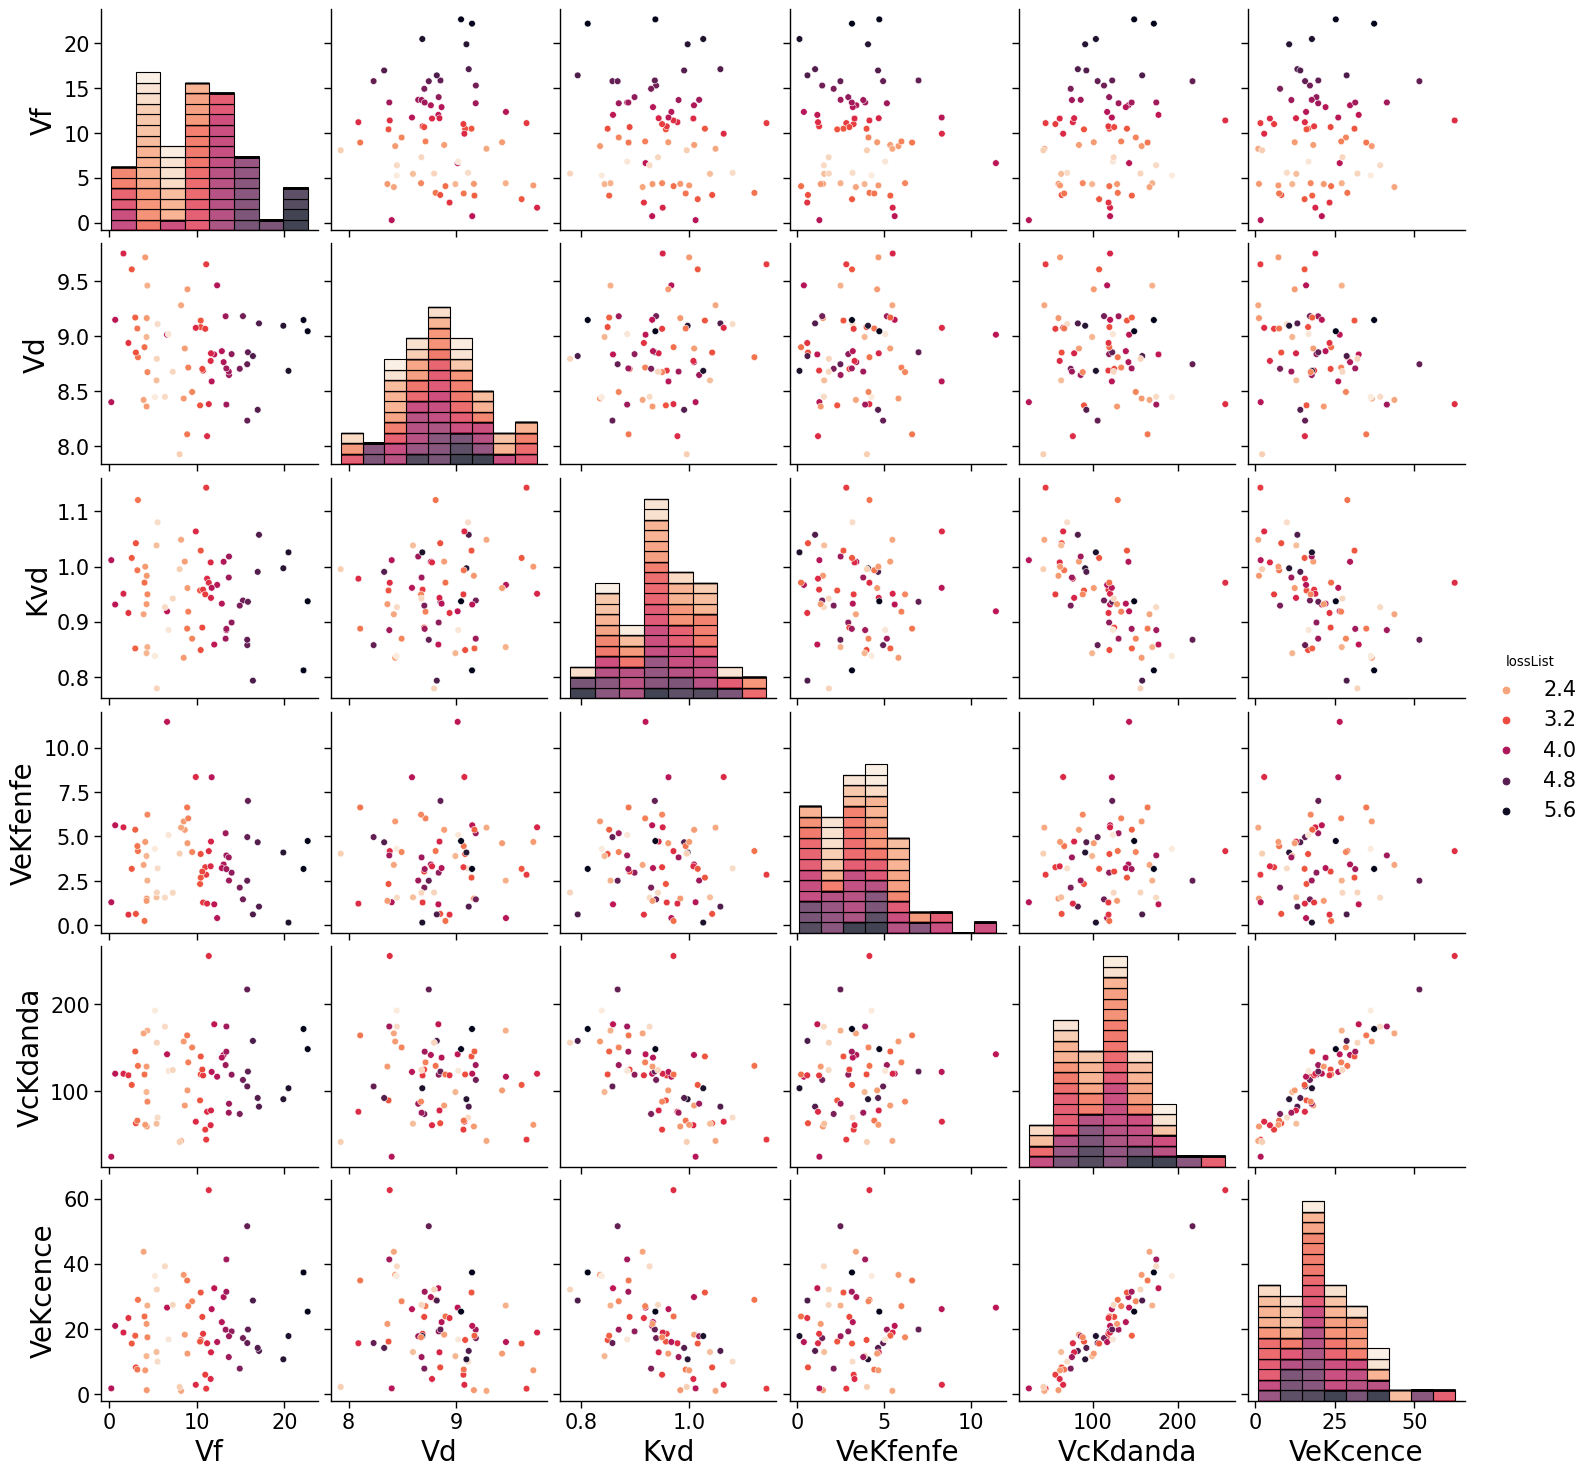

In [23]:
import pandas as pd
import seaborn as sns
sns.set_context("paper", rc={"axes.labelsize":20, "xtick.labelsize":15, "ytick.labelsize":15, "legend.fontsize":15, "axes.titlesize":20})

paramNames = ['Vf','Vd', 'Kvd', 'VeKfenfe', 'VcKdanda', 'VeKcence']
df = pd.DataFrame(filtered_parameters, columns=paramNames)
df['lossList'] = np.log(lossList)

sns.pairplot(df, hue="lossList", diag_kind='hist', diag_kws={'multiple': 'stack'},palette='rocket_r')
# sns.pairplot(df, hue="lossList", diag_kind='hist',diag_kws=dict(hue=None, color=".2"))


## Generate parameter set

In [ ]:
#############
###paths#####
#############
import sys
import os




pwd = os.getcwd()
modellingpath = pwd.rpartition("modelling")[0] + pwd.rpartition("modelling")[1]
sys.path.append(modellingpath + '/lib')
#############
from equations.parameterCreation_functions import *
#############
import numpy as np
import pandas as pd
import pickle as pkl
# %matplotlib inline
circuit_n=14
variant='fitted3'
#diffusion parameters


#maximum production parameters (V*)
# V* = V/b
# V = 10-1000
# b=0.1-1
minV = 10;maxV=1000;minb=0.1;maxb=1
Va = {'name':'Va','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}
Vb = {'name':'Vb','distribution':'loguniform', 'min':minV/maxb, 'max':maxV/minb}

Vc = {'name':'Vc','distribution':'gaussian', 'mean':pfitDict['Vc'], 'noisetosignal':0.3}
Vd = {'name':'Vd','distribution':'gaussian', 'mean':pfitDict['Vd'], 'noisetosignal':0.3}
Ve = {'name':'Ve','distribution':'gaussian', 'mean':pfitDict['Ve'], 'noisetosignal':0.3}
Vf = {'name':'Vf','distribution':'gaussian', 'mean':pfitDict['Vf'], 'noisetosignal':0.3}

V_parameters = [Va,Vb, Vc, Vd, Ve, Vf]



K1=0.0183; K2=0.0183
DUmin=0.1; DUmax=10; DVmin=0.1; DVmax=10
muU=0.0225; muV=0.0225
KdiffpromMin=0.1;KdiffpromMax=250
muLVA_estimate =1.143
muAAV_estimate =0.633
muASV_estimate=0.300 #this corresponds to mua

def Dr_(K1,K2,muU,muV,DU_,DV_):
    return (K2*DV_*muU)/(K1*DU_*muV)


def Kdiffstar(mudiff,Kdiffprom,kdiff):
    return mudiff*Kdiffprom/kdiff

def Kstar(mu,b,K):
    return mu/b*K

Dr = {'name':'Dr','distribution':'loguniform', 'min':Dr_(K1,K2,muU,muV,DUmax,DVmin), 'max':Dr_(K1,K2,muU,muV,DUmin,DVmax)}
D_parameters = [Dr]

#[] at half activation parameters (K)
minK=0.1;maxK=250

Keb = {'name':'Keb','distribution':'loguniform', 'min':Kstar(muLVA_estimate,maxb,minK), 'max':Kstar(muLVA_estimate,minb,maxK)}

Kee = {'name':'Kee','distribution':'fixed','value':0.001}

Kub = {'name':'Kub','distribution':'loguniform', 'min':Kdiffstar(muU,KdiffpromMin,K2), 'max':Kdiffstar(muU,KdiffpromMax,K2)}

Kvd = {'name':'Kvd','distribution':'gaussian', 'mean':pfitDict['Kvd'], 'noisetosignal':0.3}
Kda = {'name':'Kda','distribution':'gaussian', 'mean':pfitDict['Kda'], 'noisetosignal':0.3}
Kce = {'name':'Kce','distribution':'gaussian', 'mean':pfitDict['Kce'], 'noisetosignal':0.3}
Kfe = {'name':'Kfe','distribution':'gaussian', 'mean':pfitDict['Kfe'], 'noisetosignal':0.3}


# Kab = {'name':'Kab','distribution':'loguniform', 'min':muU_low*DU_low/k1, 'max':muU_high*DU_high/k1}
# Kbd = {'name':'Kbd','distribution':'loguniform', 'min':muV_low*DV_low/k2, 'max':muV_high*DV_high/k2}
K_parameters = [ Kub, Keb, Kee, Kvd, Kda, Kce, Kfe]



#protein degradation parameters (mu)
# mu = mux/mua
muASV = {'name':'muASV','distribution':'fixed', 'value':muASV_estimate/muASV_estimate}
muLVA = {'name':'muLVA','distribution': 'gaussian','mean':muLVA_estimate /muASV_estimate, 'noisetosignal':0.1}
mu_parameters = [muLVA,muASV]


#cooperativity parameters (n)
nvd = {'name':'nvd','distribution':'fixed', 'value':2}
nfe = {'name':'nfe','distribution':'fixed', 'value':5} #ideally hihger but we keep lower to ensure numerics work
nda = {'name':'nda','distribution':'fixed', 'value':2}
nce = {'name':'nce','distribution':'fixed', 'value':3}
nub = {'name':'nub','distribution':'fixed', 'value':1}
nee = {'name':'nee','distribution':'fixed', 'value':4}
neb = {'name':'neb','distribution':'fixed', 'value':4}
nfe = {'name':'nfe','distribution':'fixed', 'value':8}
n_parameters = [nub,nee,neb,nvd,nda,nce,nfe]



plotDistributions=False
if plotDistributions == True:
    D_parameters = [Dr, Dr]
    nsamples=10
    parameterTypeList = [ D_parameters  , V_parameters , K_parameters , mu_parameters , n_parameters]

    for parameterType in parameterTypeList:
        stackedDistributions = preLhs(parameterType)
        lhsDist = lhs(stackedDistributions,nsamples)
        lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterType])
        plotDist(parameterType,lhsDist_df)

createParams=True
if createParams == True:
    nsamples=2000000
    # nsamples=int(sys.argv[1])
    # nsamples=14
    parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # parameterDictList = [DU, DV, bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, Kbd, Kab, Kda, Kfe, Kee, Keb, Kce, KaTc, Kiptg, muLVA, muAAV, muASV, muUb, muVb, muaTc, muU, muV, nbd, nab, nda, nfe, nee, neb, nce, naTc, niptg, k1, k2, iptg]
    stackedDistributions = preLhs(parameterDictList)
    lhsDist = lhs(stackedDistributions,nsamples)
    lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
    # plotDist(parameterDictList,lhsDist_df)
    pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/fitted_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))

    print(lhsDist_df)


100%|██████████| 23/23 [00:00<00:00, 1288.16it/s]

          Dr          Va          Vb          Vc         Vd          Ve  \
0  10.817215   11.375166   25.304699  105.397622   8.076719   99.437848   
1   1.367528   42.032246   41.442983  136.839168   5.387273  163.076918   
2   0.068363  137.484701   34.719502   73.489436  11.026822  118.481171   
3   0.036289   16.404543   14.931716  114.646458  11.231837   53.796519   
4   0.016228  763.703096   82.003940   82.275032   8.235786  111.013660   
5  49.795844  441.684497  257.046044   86.750816  10.134210   74.751052   
6  18.014258   28.286884  193.698044  123.876095   9.475763  106.685333   
7   0.649759  187.031719  689.461397   59.050610   7.441223   92.009377   
8   4.946722  273.504065  580.956004   95.204854   6.078465   75.768121   
9   0.241899   65.676753  102.987043  152.449598  12.283782  135.733949   

          Vf         Kub         Keb    Kee  ...       Kfe     muLVA  muASV  \
0  13.715130    0.466008   46.889791  0.001  ...  0.366084  3.706912    1.0   
1   7.849798    

In [ ]:
lhsDist_df

pfit_df = pd.DataFrame(pfit_hesian, columns =['Vf', 'Kvd', 'Ve', 'Kfe'])
lhsDist_df=pd.concat([lhsDist_df, pfit_df], axis=1)
lhsDist_df

In [ ]:

Km_list = ['Kda', 'Kab', 'Keb', 'Kbd', 'Kfe',  'Kce' ]
KtoV = {'Kda': 'VD', 'Kab': 'VA', 'Keb': 'VE', 'Kbd': 'VB', 'Kfe': 'VF','Kce': 'VC' }

def checkBalance(par_dict):
    balanceDict = {}
    for Km in Km_list:
        # print(Km)
        Vx =par_dict[KtoV[Km]]
        Kxy = par_dict[Km]
        if Kxy >= 1 and Kxy <= Vx:
            balanceDict[Km] = 'Balanced'
        elif Kxy > 0.1 and Kxy < Vx*10:
            balanceDict[Km] ='Semi balanced'
        elif Kxy <= 0.1 or Kxy >= Vx*10:
            balanceDict[Km] ='Not balanced'
        else:
            print('ERROR!!!!!!!!!')

    if 'Not balanced' in balanceDict.values():
        return 'Not balanced'
    elif 'Semi balanced'  in balanceDict.values():
        return 'Semi balanced'
    elif all(x == 'Balanced' for x in balanceDict.values()):
        return 'Balanced'
    

createBalancedParams=True
if createBalancedParams == True:
    seed=0
    nsamples=1000000
    parameterDictList = D_parameters  + V_parameters + K_parameters + mu_parameters + n_parameters
    # parameterDictList = [DU, DV, bA, bB, bC, bD, bE, bF, VA, VB, VC, VD, VE, VF, Kbd, Kab, Kda, Kfe, Kee, Keb, Kce, KaTc, Kiptg, muLVA, muAAV, muASV, muUb, muVb, muaTc, muU, muV, nbd, nab, nda, nfe, nee, neb, nce, naTc, niptg, k1, k2, iptg]
    stackedDistributions = preLhs(parameterDictList)
    balancedDf = pd.DataFrame()
    semiBalancedDf = pd.DataFrame()
    notBalancedDf = pd.DataFrame()
    while len(balancedDf)<nsamples:
        lhsDist = lhs(stackedDistributions,nsamples, seed = seed, tqdm_disable = True)
        lhsDist_df = pd.DataFrame(data = lhsDist, columns=[parameter['name'] for parameter in parameterDictList])
        #check balance

        balanceList = []    
        for parID in lhsDist_df.index:
            par_dict = lhsDist_df.loc[parID].to_dict()
            balanceList.append(checkBalance(par_dict))
        lhsDist_df['balance'] = balanceList
        
        #separate 3df
        balancedDfPre = lhsDist_df[lhsDist_df['balance']=='Balanced']
        semiBalancedDfPre = lhsDist_df[lhsDist_df['balance']=='Semi balanced']
        notBalancedDfPre = lhsDist_df[lhsDist_df['balance']=='Not balanced']
        
        #concat to df
        if len(balancedDf)<nsamples:
            balancedDf = pd.concat([balancedDf, balancedDfPre], ignore_index=True)
        if len(semiBalancedDf)<nsamples:
            semiBalancedDf = pd.concat([semiBalancedDf, semiBalancedDfPre], ignore_index=True)
        if len(notBalancedDf)<nsamples:
            notBalancedDf = pd.concat([notBalancedDf, notBalancedDfPre], ignore_index=True)

        seed+=1
        print(seed, len(balancedDf))
    
        pkl.dump(balancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_balanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        pkl.dump(semiBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_semiBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        pkl.dump(notBalancedDf[:nsamples], open(modellingpath + '/3954/paper/input/balanced_parameterfiles/df_circuit%r_variant%s_%rparametersets_notBalanced.pkl'%(circuit_n,variant,nsamples), 'wb'))
        # pkl.dump(lhsDist_df, open(modellingpath + '/3954/paper/input/lhs_parameterfiles/df_circuit%r_variant%s_%rparametersets.pkl'%(circuit_n,variant,nsamples), 'wb'))






NameError: name 'circuit_n' is not defined